In [1]:
from auto_ml_regression.automl_pipeline import AutoMLPipeline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import numpy as np
from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error

data = pd.read_csv('../../datasets/coffee_shop_dataset/coffee_shop_revenue.csv')
target_col="Daily_Revenue"
N_SEGMENTS = 2
# cols_to_del = ['Country']
# data = data.drop(columns=cols_to_del).dropna(subset=target_col)

cat_features = data.select_dtypes(include='object').columns.to_list()
num_features = data.select_dtypes(exclude='object').columns.to_list()
num_features.remove(target_col)
cat_features_saved = [f'CAT_{i}' for i in cat_features]

# Инициализация
pipeline = AutoMLPipeline(
    num_features=num_features,
    cat_features=cat_features,
    target_col=target_col,
    test_size=0.3,
    n_segments=N_SEGMENTS   # Можно указать любое количество сегментов
)

/Users/andrejurkinair/Documents/diploma_practice/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# График общего распределения целевого признака

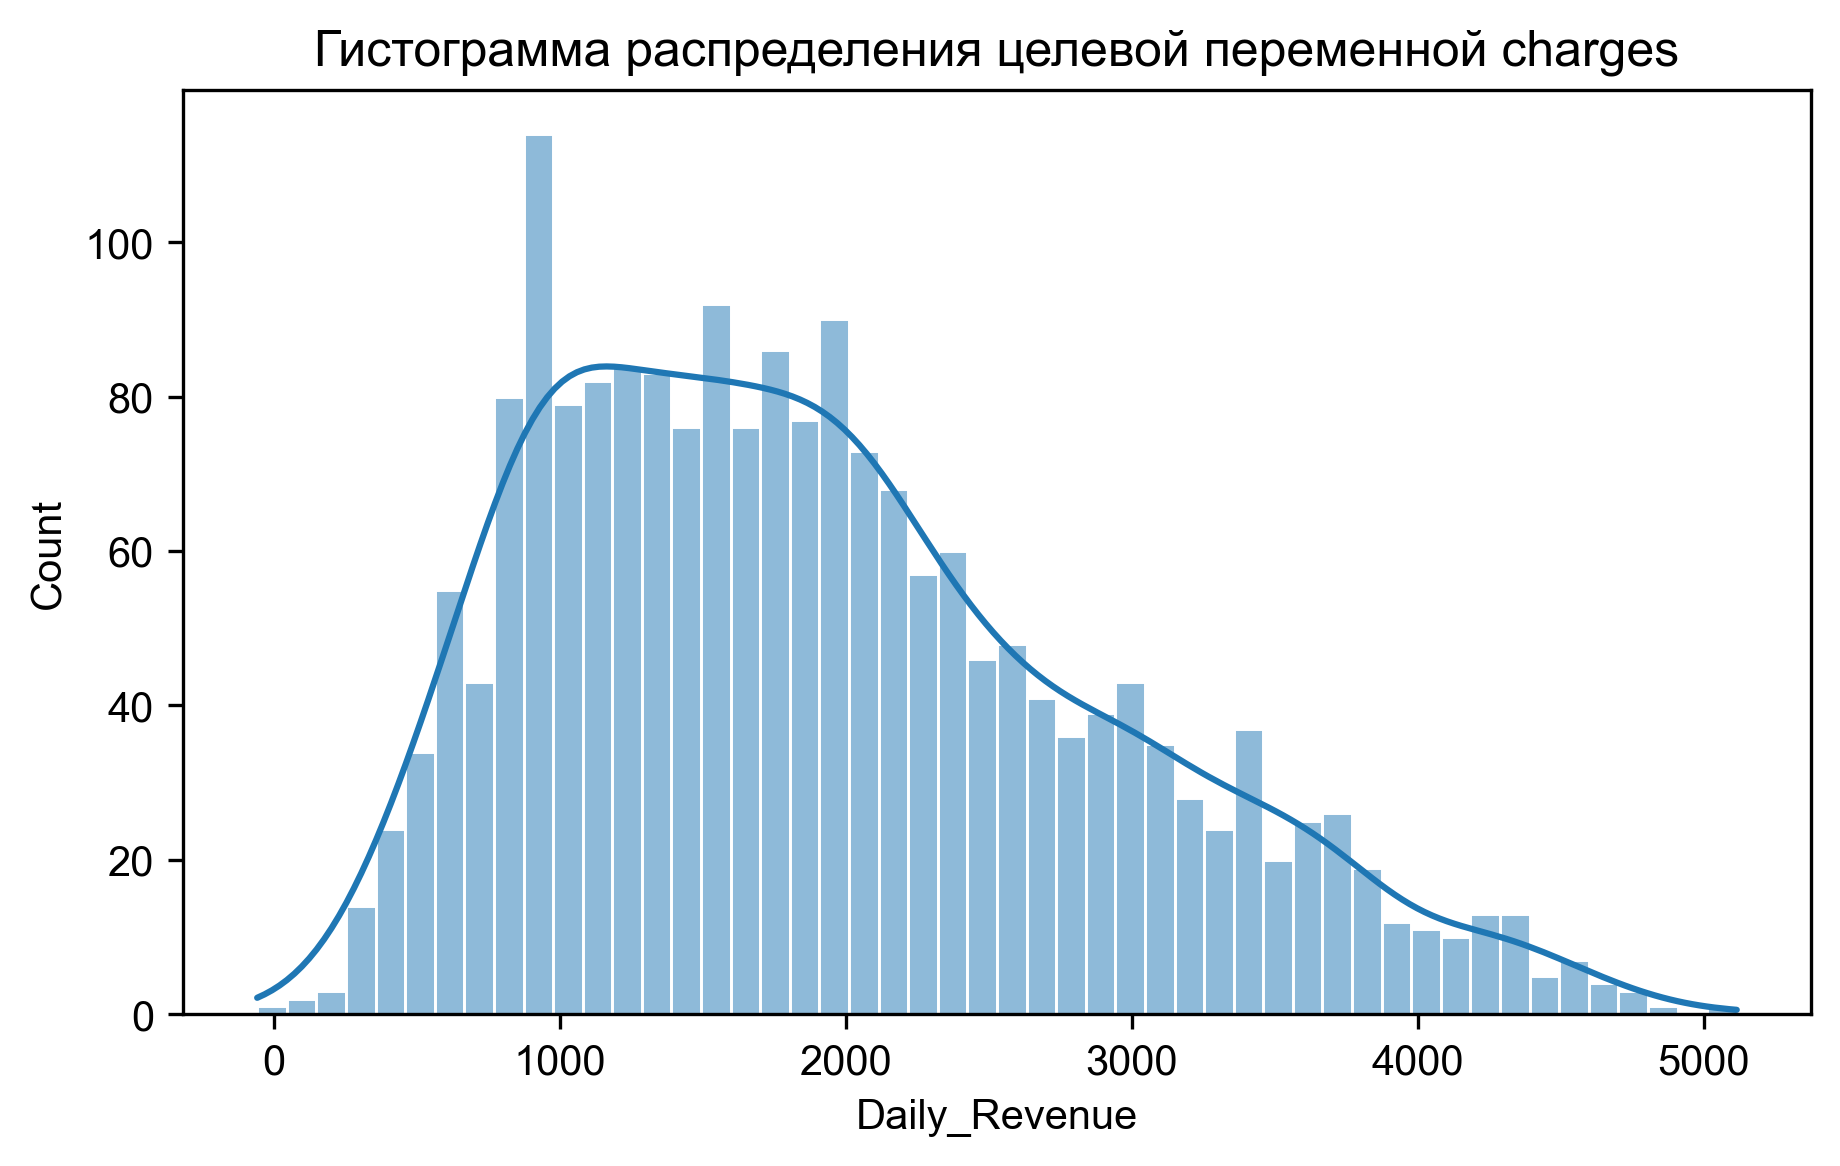

In [2]:
plt.figure(figsize=(7,4), dpi=300)
plt.title("Гистограмма распределения целевой переменной charges")
sns.set_style("whitegrid")
sns.histplot(data[target_col], bins=50, kde=True)
plt.show();

# Предобработка данных

In [3]:
# Запуск полного пайплайна
pipeline.preprocess_data(data)

In [4]:
train_df = pipeline.train_data
test_df = pipeline.test_data

In [5]:
train_df

,Number_of_Customers_Per_Day,Average_Order_Value,Operating_Hours_Per_Day,Number_of_Employees,Marketing_Spend_Per_Day,Location_Foot_Traffic,Daily_Revenue
0,0.966592,0.882667,0.727273,0.500000,0.379008,0.334036,4273.33
1,0.133630,0.653333,0.545455,1.000000,0.232221,0.826133,1056.86
2,0.819599,0.121333,0.090909,0.083333,0.048262,0.164384,1457.26
3,0.942094,0.692000,1.000000,0.000000,0.100997,0.527924,3290.21
4,0.719376,0.406667,0.636364,0.916667,0.460990,0.162276,2082.70
...,...,...,...,...,...,...,...
1395,0.917595,0.394667,0.272727,0.750000,0.320657,0.340358,2609.64
1396,0.808463,0.290667,1.000000,1.000000,0.654508,0.268704,2339.46
1397,0.487751,0.760000,0.636364,0.083333,0.190964,0.414120,2183.37
1398,0.175947,0.765333,0.454545,0.833333,0.403721,0.742887,989.97


# OLS

In [6]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(train_df[num_features+cat_features], train_df[target_col])

LinearRegression()

In [7]:
from sklearn import metrics

y_true = test_df[target_col]
y_pred = lr.predict(test_df[num_features+cat_features])

r2 = metrics.r2_score(y_true, y_pred)
mse = metrics.mean_squared_error(y_true, y_pred)
mae = metrics.mean_absolute_error(y_true, y_pred)
mape = metrics.mean_absolute_percentage_error(y_true, y_pred)

print(f"R2 = {r2}")
print(f"MSE = {mse}")
print(f"RMSE = {mse**0.5}")
print(f"MAE = {mae}")
print(f"MAPE = {mape}")

R2 = 0.8839371101373258
MSE = 103948.21989686815
RMSE = 322.4100182948231
MAE = 253.52286218417058
MAPE = 0.1996142963374424


/var/folders/dy/q_kmpbjj54q1glfr1wthxzhw0000gn/T/ipykernel_53653/2350633174.py:25: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  scatter = sns.scatterplot(


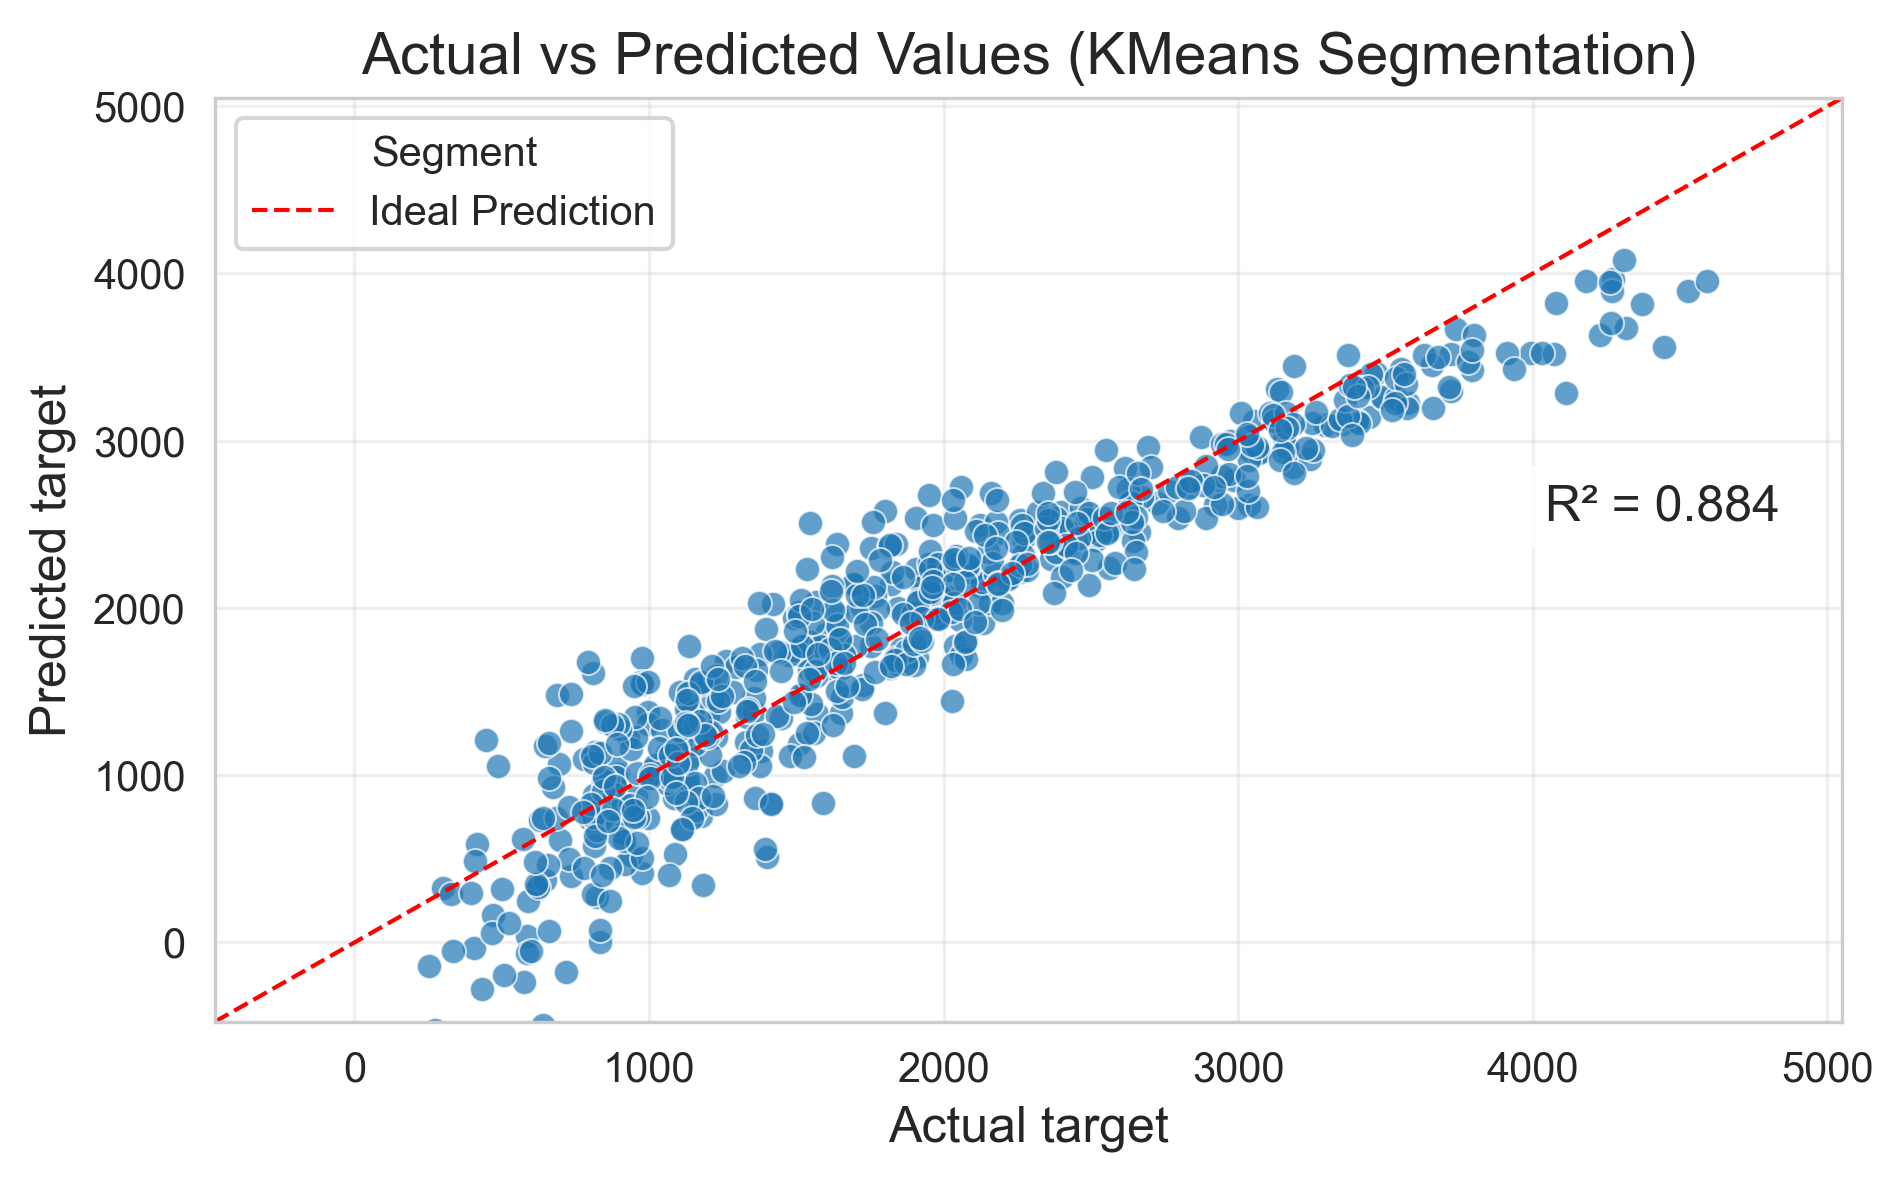

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

# Предположим, у нас есть:
# y_test - истинные значения на тестовой выборке
# y_pred - предсказания модели CatBoost+KMeans на тестовой выборке
y_test = y_true

# Создаем DataFrame для визуализации
plot_data = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,# Добавляем информацию о сегментах
})

# Определяем границы осей (минимальное/максимальное значение + 10%)
ax_min = min(y_test.min(), y_pred.min()) * 0.9
ax_max = max(y_test.max(), y_pred.max()) * 1.1

# Создаем фигуру
plt.figure(figsize=(7, 4), dpi=300)

# Диаграмма рассеяния с цветовым кодированием по сегментам
scatter = sns.scatterplot(
    data=plot_data,
    x='Actual',
    y='Predicted',
    palette='viridis',
    alpha=0.7
)

# Добавляем идеальную линию
ideal_line = plt.plot(
    [ax_min, ax_max],
    [ax_min, ax_max],
    '--',
    color='red',
    linewidth=1,
    label='Ideal Prediction'
)

# Настройки графика
plt.title('Actual vs Predicted Values (KMeans Segmentation)', fontsize=14)
plt.xlabel('Actual target', fontsize=12)
plt.ylabel('Predicted target', fontsize=12)
plt.xlim(ax_min, ax_max)
plt.ylim(ax_min, ax_max)
plt.legend(title='Segment')
plt.grid(True, alpha=0.3)

# Добавляем коэффициент R² в аннотацию
r2 = metrics.r2_score(y_test, y_pred)
plt.text(
    x=ax_max*0.8,
    y=ax_max*0.5,
    s=f'R² = {r2:.3f}',
    fontsize=12,
    bbox=dict(facecolor='white', alpha=0.8)
)

plt.show()

# Huber

In [9]:
# 2. Определяем целевую функцию для Optuna
def objective(trial):
    # Предлагаем Optuna подбирать гиперпараметры
    epsilon = trial.suggest_float("epsilon", 1.0, 3.0, step=0.1)  # Оптимальный диапазон для epsilon
    alpha = trial.suggest_float("alpha", 0.0001, 1.0, log=True)    # Логарифмический масштаб для alpha

    # Создаем модель Huber с текущими гиперпараметрами
    model = HuberRegressor(epsilon=epsilon, alpha=alpha, max_iter=1000)

    # Используем кросс-валидацию (KFold) для оценки
    kf = KFold(n_splits=3, shuffle=True, random_state=2025)
    scores = cross_val_score(model, train_df[num_features+cat_features], train_df[target_col], 
                             cv=kf, scoring=make_scorer(mean_squared_error))
    
    scores_mae = cross_val_score(model, train_df[num_features+cat_features], train_df[target_col], 
                             cv=kf, scoring=make_scorer(mean_absolute_error))

    # Optuna минимизирует значение, поэтому берем средний MSE
    return np.mean(scores) + np.mean(scores_mae)

study = optuna.create_study(direction="minimize")  # Минимизируем MSE
study.optimize(objective, n_trials=50, show_progress_bar=False)
best_params = study.best_params

huber = HuberRegressor(max_iter=1000, **best_params)
huber.fit(train_df[num_features+cat_features], train_df[target_col])

[I 2025-05-20 23:44:31,238] A new study created in memory with name: no-name-2f09f9eb-a567-4ef5-bbfc-56469e8ef7fe
[I 2025-05-20 23:44:31,289] Trial 0 finished with value: 105241.46279468416 and parameters: {'epsilon': 2.7, 'alpha': 0.0013185266213711219}. Best is trial 0 with value: 105241.46279468416.
[I 2025-05-20 23:44:31,317] Trial 1 finished with value: 105227.2184490851 and parameters: {'epsilon': 3.0, 'alpha': 0.001204379009890295}. Best is trial 1 with value: 105227.2184490851.
[I 2025-05-20 23:44:31,337] Trial 2 finished with value: 770722.455439335 and parameters: {'epsilon': 1.6, 'alpha': 0.595888575346574}. Best is trial 1 with value: 105227.2184490851.
[I 2025-05-20 23:44:31,365] Trial 3 finished with value: 105145.95924399818 and parameters: {'epsilon': 1.6, 'alpha': 0.0015815396834512841}. Best is trial 3 with value: 105145.95924399818.
[I 2025-05-20 23:44:31,409] Trial 4 finished with value: 236387.60913025067 and parameters: {'epsilon': 1.0, 'alpha': 0.0781494520685673

HuberRegressor(alpha=0.0006801581831070409, epsilon=1.4, max_iter=1000)

In [10]:
y_true = test_df[target_col]
y_pred = huber.predict(test_df[num_features+cat_features])

r2 = metrics.r2_score(y_true, y_pred)
mse = metrics.mean_squared_error(y_true, y_pred)
mae = metrics.mean_absolute_error(y_true, y_pred)
mape = metrics.mean_absolute_percentage_error(y_true, y_pred)

print(f"R2 = {r2}")
print(f"MSE = {mse}")
print(f"RMSE = {mse**0.5}")
print(f"MAE = {mae}")
print(f"MAPE = {mape}")

R2 = 0.8838138351397675
MSE = 104058.6274230735
RMSE = 322.58119508594035
MAE = 253.47445945007308
MAPE = 0.19981678253454996


# Catboost 

In [11]:
import optuna
from catboost import CatBoostRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

def objective(trial, X, y):
    # Разделение данных на train и validation
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2025)
    
    # Параметры для перебора
    params = {
        'iterations': trial.suggest_int('iterations', 100, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 10.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations', 1, 15),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'boosting_type': 'Plain',
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'od_wait': trial.suggest_int('od_wait', 10, 50),
        'one_hot_max_size': trial.suggest_int('one_hot_max_size', 2, 255),
        'verbose': False,
        'random_state': 2025,
    }
    
    # Параметры глубины
    if params['grow_policy'] == 'Lossguide':
        params['max_leaves'] = trial.suggest_int('max_leaves', 4, 64)
    elif params['grow_policy'] == 'Depthwise':
        params['max_depth'] = trial.suggest_int('max_depth', 2, 12)
    
    # Указание категориальных признаков (если есть)
    if cat_features:
        params['cat_features'] = cat_features_saved
    
    # Создание и обучение модели
    model = CatBoostRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        verbose=0
    )
    
    # Предсказание на валидации
    y_pred = model.predict(X_val)
    
    # Метрика качества (можно выбрать другую)
    rmse = metrics.mean_squared_error(y_val, y_pred)**0.5
    # Или можно использовать R2: return r2_score(y_val, y_pred)
    return rmse

# Пример использования:
study = optuna.create_study(direction='minimize')  # Для RMSE минимизируем
study.optimize(lambda trial: objective(trial, 
                                     train_df[num_features+cat_features_saved], 
                                     train_df[target_col]), 
                                     n_trials=30)
best_params = study.best_params

[I 2025-05-20 23:44:37,684] A new study created in memory with name: no-name-fbd73ea1-2bb2-42f3-a3a1-3a8bfad286e9
[I 2025-05-20 23:44:38,021] Trial 0 finished with value: 228.86753617455844 and parameters: {'iterations': 549, 'learning_rate': 0.050607377827905635, 'l2_leaf_reg': 0.009550346908846525, 'random_strength': 0.002657597911615242, 'bagging_temperature': 4.588421188903813, 'border_count': 142, 'min_data_in_leaf': 99, 'leaf_estimation_iterations': 6, 'grow_policy': 'Lossguide', 'od_type': 'IncToDec', 'od_wait': 29, 'one_hot_max_size': 21, 'max_leaves': 6}. Best is trial 0 with value: 228.86753617455844.
[I 2025-05-20 23:44:38,134] Trial 1 finished with value: 227.57161956997473 and parameters: {'iterations': 697, 'learning_rate': 0.07041404861565571, 'l2_leaf_reg': 2.6442660030450176, 'random_strength': 0.0022597377072873927, 'bagging_temperature': 9.163839999899597, 'border_count': 147, 'min_data_in_leaf': 69, 'leaf_estimation_iterations': 8, 'grow_policy': 'Lossguide', 'od_ty

In [12]:
cat_model = CatBoostRegressor(**best_params, cat_features = cat_features_saved, verbose = False,
        random_state= 2025, boosting_type='Plain')
cat_model.fit(train_df[num_features+cat_features_saved], train_df[target_col])

In [13]:
y_true = test_df[target_col]
y_pred = cat_model.predict(test_df[num_features+cat_features_saved])

r2 = metrics.r2_score(y_true, y_pred)
mse = metrics.mean_squared_error(y_true, y_pred)
mae = metrics.mean_absolute_error(y_true, y_pred)
mape = metrics.mean_absolute_percentage_error(y_true, y_pred)

print(f"R2 = {r2}")
print(f"MSE = {mse}")
print(f"RMSE = {mse**0.5}")
print(f"MAE = {mae}")
print(f"MAPE = {mape}")

R2 = 0.9507853762435541
MSE = 44077.590506575
RMSE = 209.94663728332253
MAE = 167.6289192791445
MAPE = 0.1190368573024761


# My Pipeline

In [2]:
%%time

N_SEGMENTS=2
# Инициализация
pipeline = AutoMLPipeline(
    num_features=num_features,
    cat_features=cat_features,
    target_col=target_col,
    test_size=0.3,
    n_segments=N_SEGMENTS
)

# Запуск полного пайплайна
pipeline.preprocess_data(data)
pipeline.segment_data(plot=False, use_optuna=True, depth=4)
pipeline.train_classifier(n_trials=30)
pipeline.train_regressors(model_type='huber', n_trials=40, cv=4)

[I 2025-05-20 23:56:28,996] A new study created in memory with name: no-name-3ca3186d-19e0-4a3e-895e-0a422b94d744
[I 2025-05-20 23:56:31,409] Trial 0 finished with value: -953.3786604076032 and parameters: {'depth': 4, 'learning_rate': 0.04865406264539821, 'l2_leaf_reg': 1.828910992542457}. Best is trial 0 with value: -953.3786604076032.
[I 2025-05-20 23:56:31,976] Trial 1 finished with value: -940.7828847834556 and parameters: {'depth': 3, 'learning_rate': 0.07117182240619695, 'l2_leaf_reg': 9.814283318805055}. Best is trial 1 with value: -940.7828847834556.
[I 2025-05-20 23:56:32,577] Trial 2 finished with value: -804.7661899773785 and parameters: {'depth': 4, 'learning_rate': 0.26726689208725085, 'l2_leaf_reg': 6.545426143762588}. Best is trial 2 with value: -804.7661899773785.
[I 2025-05-20 23:56:32,603] Trial 3 finished with value: -842.1760476861626 and parameters: {'depth': 2, 'learning_rate': 0.2419695982578573, 'l2_leaf_reg': 8.840569976498866}. Best is trial 2 with value: -80

Classification Report: TRAIN
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       514
           1       1.00      1.00      1.00       886

    accuracy                           1.00      1400
   macro avg       1.00      1.00      1.00      1400
weighted avg       1.00      1.00      1.00      1400

ROC AUC = 1.0
TEST ROC AUC = 1.0000


[I 2025-05-20 23:56:40,265] Trial 7 finished with value: -308.1760430223692 and parameters: {'epsilon': 5.979317348488116, 'alpha': 0.03826106909292964, 'fit_intercept': False}. Best is trial 4 with value: -301.0457871469196.
[I 2025-05-20 23:56:40,287] Trial 8 finished with value: -699.5445502752714 and parameters: {'epsilon': 8.973648823475973, 'alpha': 0.2693896783066742, 'fit_intercept': False}. Best is trial 4 with value: -301.0457871469196.
[I 2025-05-20 23:56:40,312] Trial 9 finished with value: -509.35091554249703 and parameters: {'epsilon': 6.672545559078963, 'alpha': 0.12447656386810556, 'fit_intercept': False}. Best is trial 4 with value: -301.0457871469196.
[I 2025-05-20 23:56:40,344] Trial 10 finished with value: -221.35160220918775 and parameters: {'epsilon': 7.73520323307067, 'alpha': 0.013211874771133416, 'fit_intercept': True}. Best is trial 10 with value: -221.35160220918775.
[I 2025-05-20 23:56:40,377] Trial 11 finished with value: -214.59135306718048 and parameters:

CPU times: user 11.9 s, sys: 10 s, total: 21.9 s
Wall time: 13.5 s


In [34]:
pipeline.segmenter.depth

4

In [3]:
metrics_df = pipeline.evaluate_test()
metrics_df

,r2,mse,rmse,mae,mape
0,0.93647,56898.521606,238.53411,188.024175,0.13971


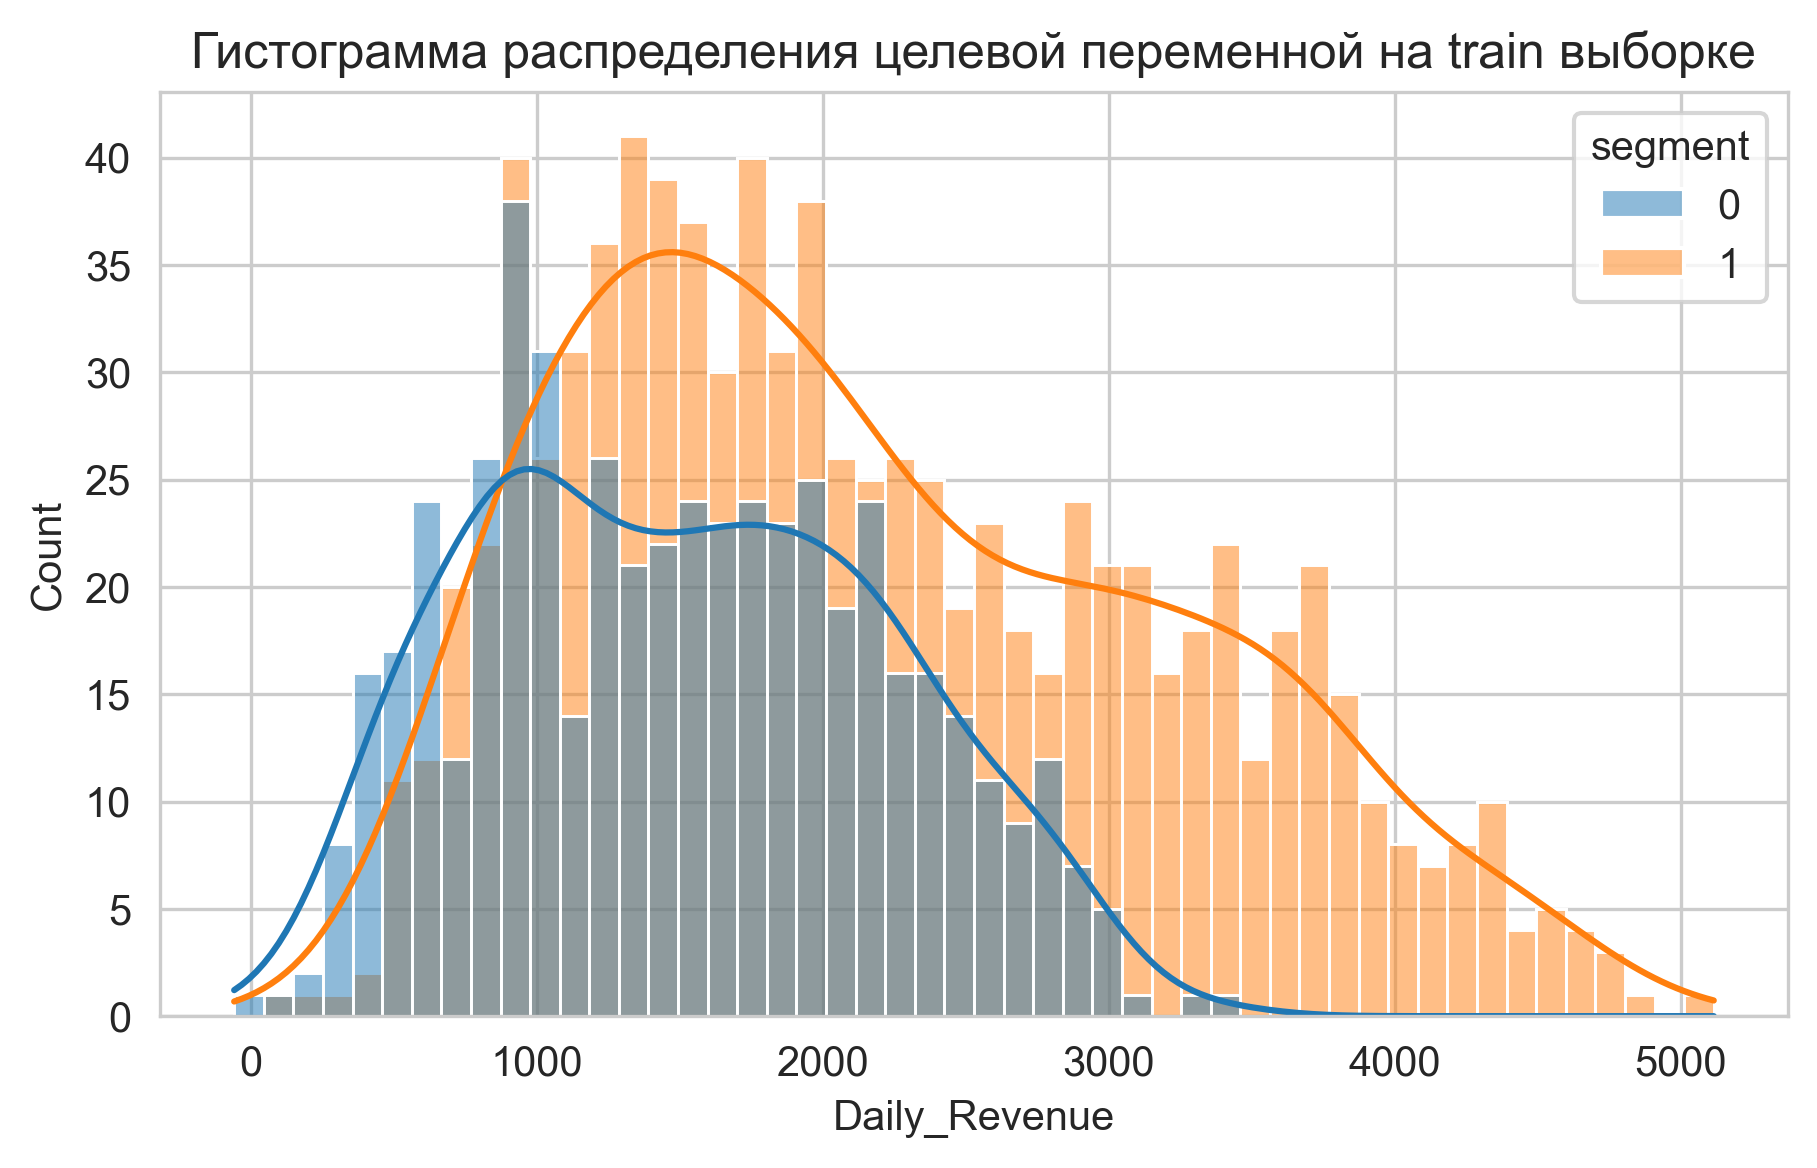

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,4), dpi=300)
plt.title("Гистограмма распределения целевой переменной на train выборке")
sns.set_style("whitegrid")
sns.histplot(pipeline.segmented_train, x=target_col, hue='segment', bins=50, kde=True)
plt.show();

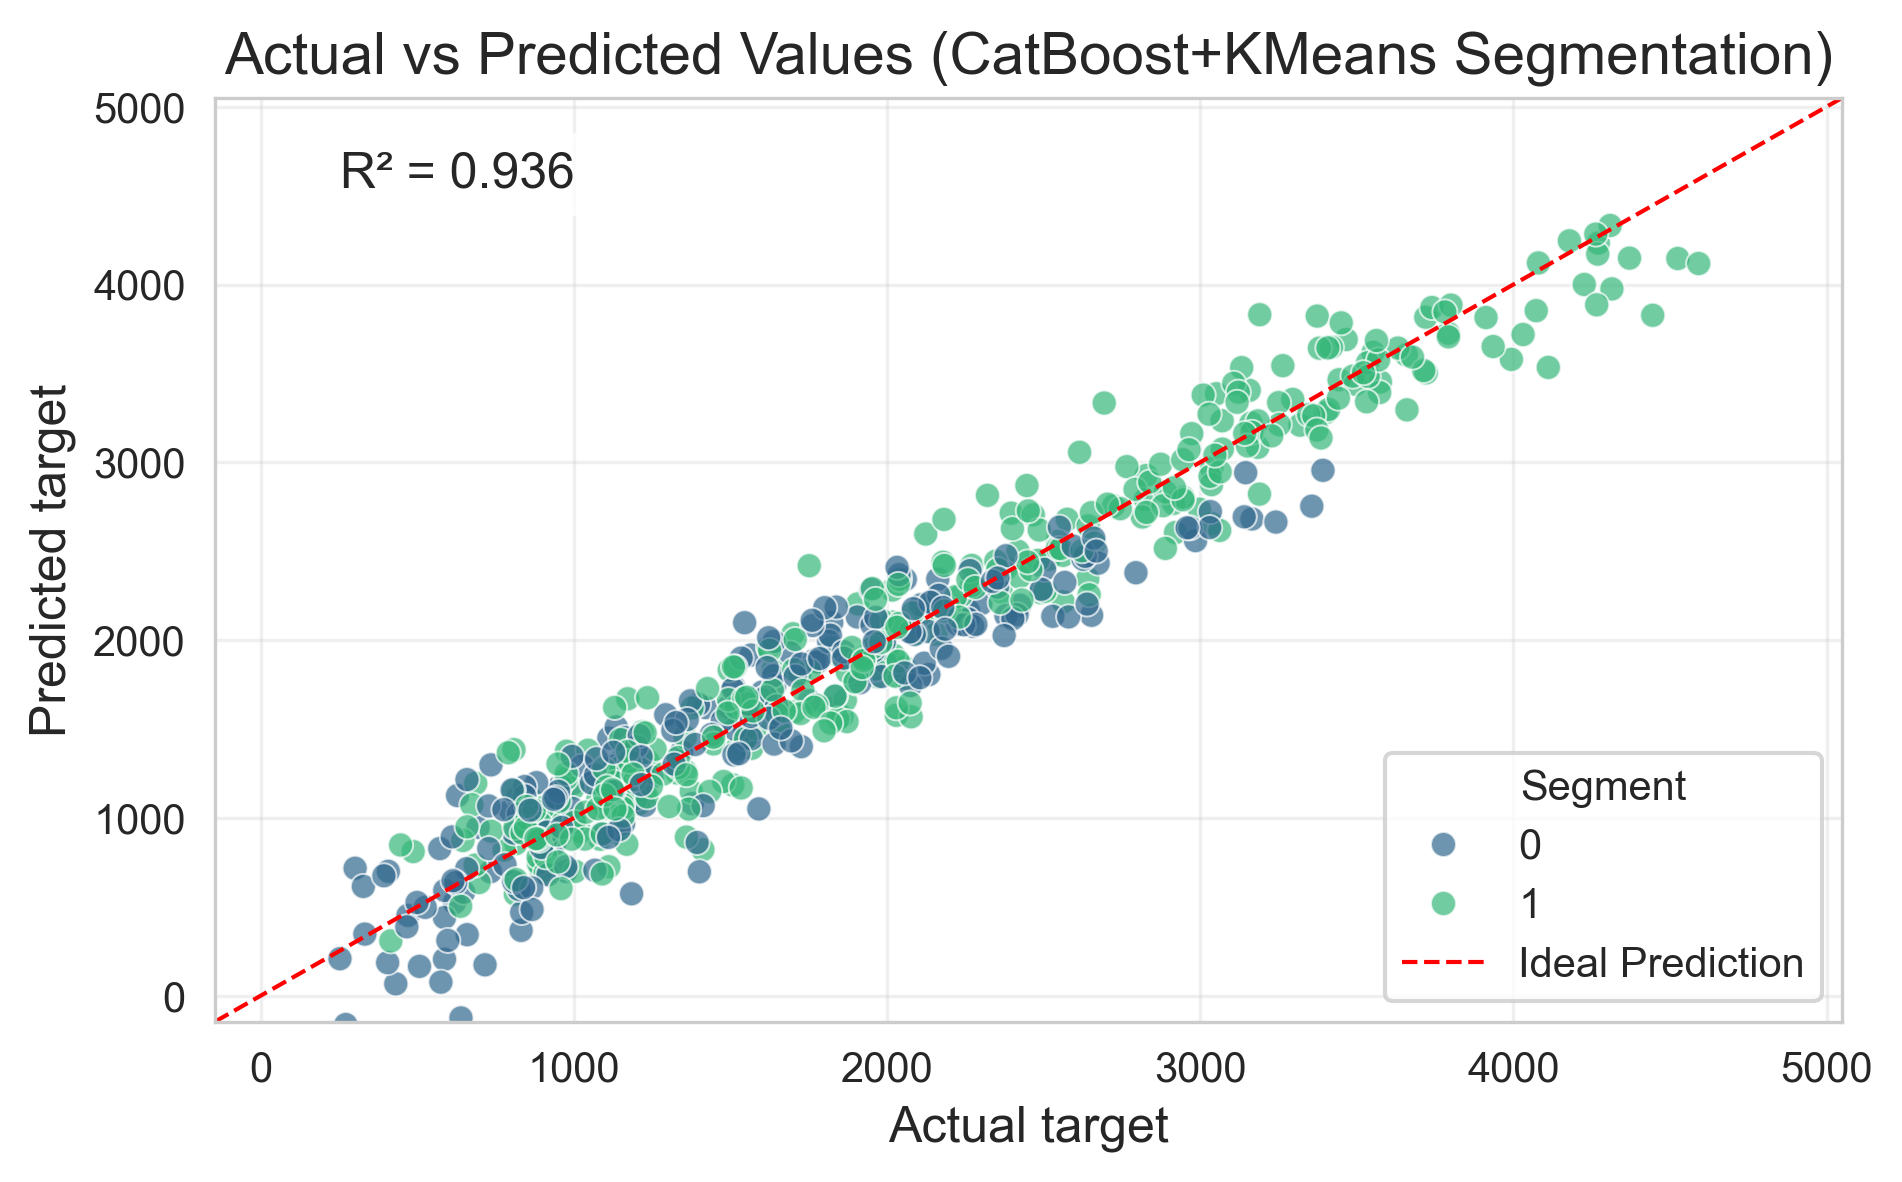

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

# Предположим, у нас есть:
# y_test - истинные значения на тестовой выборке
# y_pred - предсказания модели CatBoost+KMeans на тестовой выборке
y_test = pipeline.segmented_test[target_col]
y_pred = pipeline.regressor.predict(pipeline.segmented_test[num_features+cat_features], segments=pipeline.segmented_test['segment_preds'])

# Создаем DataFrame для визуализации
plot_data = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Segment': pipeline.segmented_test['segment']  # Добавляем информацию о сегментах
})

# Определяем границы осей (минимальное/максимальное значение + 10%)
ax_min = min(y_test.min(), y_pred.min()) * 0.9
ax_max = max(y_test.max(), y_pred.max()) * 1.1

# Создаем фигуру
plt.figure(figsize=(7, 4), dpi=300)

# Диаграмма рассеяния с цветовым кодированием по сегментам
scatter = sns.scatterplot(
    data=plot_data,
    x='Actual',
    y='Predicted',
    hue='Segment',
    palette='viridis',
    alpha=0.7
)

# Добавляем идеальную линию
ideal_line = plt.plot(
    [ax_min, ax_max],
    [ax_min, ax_max],
    '--',
    color='red',
    linewidth=1,
    label='Ideal Prediction'
)

# Настройки графика
plt.title('Actual vs Predicted Values (CatBoost+KMeans Segmentation)', fontsize=14)
plt.xlabel('Actual target', fontsize=12)
plt.ylabel('Predicted target', fontsize=12)
plt.xlim(ax_min, ax_max)
plt.ylim(ax_min, ax_max)
plt.legend(title='Segment')
plt.grid(True, alpha=0.3)

# Добавляем коэффициент R² в аннотацию
r2 = metrics.r2_score(y_test, y_pred)
plt.text(
    x=ax_max*0.05,
    y=ax_max*0.9,
    s=f'R² = {r2:.3f}',
    fontsize=12,
    bbox=dict(facecolor='white', alpha=0.8)
)

plt.show()